# Image Super Resolution #1
<hr style='height:5px'>
kwanki.ahn<br>
2019/06/08(Sun) skeleton<br>
2019/06/15(Sat) update<br>
refer :<br>
&nbsp;&nbsp;https://arxiv.org/abs/1501.00092<br>
&nbsp;&nbsp;https://jamiekang.github.io/2017/04/24/image-super-resolution-using-deep-convolutional-networks/<br>
&nbsp;&nbsp;https://github.com/titu1994/Image-Super-Resolution<br>
&nbsp;&nbsp;https://github.com/jormeli/srcnn-keras<br>
&nbsp;&nbsp;https://github.com/MarkPrecursor/SRCNN-keras<br>
<hr style='height:5px'>



# Dataset

In [1]:
# image dataset source : https://data.vision.ee.ethz.ch/cvl/DIV2K/
# Let's start with
# (NTIRE 2017) Low Res Images:
#     Train Data Track 2 unknown downgrading operators x2 (LR images)
#     Validation Data Track 2 unknown downgrading operators x2 (LR images)
# High Resolution Images:
#     Train Data (HR images)
#     Validation Data (HR images)

# Download image
# !wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_unknown_X2.zip
# !wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
# !wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_unknown_X2.zip
# !wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip

# unzip into
# /home/jupyter/sr/image_sr_dataset/DIV2K_train_LR_unknown/X2/
# /home/jupyter/sr/image_sr_dataset/DIV2K_train_HR
# /home/jupyter/sr/image_sr_dataset/DIV2K_valid_LR_unknown/X2/
# /home/jupyter/sr/image_sr_dataset/DIV2K_valid_HR

# Init

In [2]:
from __future__ import print_function, division

from keras.models import Model
from keras.layers import Concatenate, Add, Average, Input, Dense, Flatten, BatchNormalization, Activation, LeakyReLU
from keras.layers.convolutional import Convolution2D, MaxPooling2D, UpSampling2D, Convolution2DTranspose
from keras import backend as K
from keras.utils.np_utils import to_categorical
import keras.callbacks as callbacks
import keras.optimizers as optimizers

Using TensorFlow backend.


# Function

In [3]:
import keras, tensorflow
keras.__version__, tensorflow.__version__

('2.0.6', '1.13.1')

In [4]:
def list_files(path_in):
    from os import listdir
    from os.path import isfile, join
    onlyfiles = [f for f in listdir(path_in) if isfile(join(path_in, f))]
    return onlyfiles

# UNIT TEST
sorted(list_files("/home/jupyter/src-github/ai-study/sr/image_sr_dataset/DIV2K_train_LR_unknown/X2/"))[:3]

['0001x2.png', '0002x2.png', '0003x2.png']

In [5]:
def get_image_data(path_in, K=987654321, resize=None, force_down_quality=None):
    print ("== get_image_data() start")
    files = sorted(list_files(path_in))[:K]
    import scipy
    image_data_l = []
    for f in files:
        # print "  reading..{}".format(f)
        read_data = scipy.misc.imread("{}{}".format(path_in, f))
        if resize is not None:
            read_data = scipy.misc.imresize(read_data, resize)
        if force_down_quality is not None:
            scale = force_down_quality
            read_data = scipy.misc.imresize(read_data, 1.0/scale, 'bicubic')
            read_data = scipy.misc.imresize(read_data, scale/1.0, 'bicubic')
        image_data_l.append(read_data)
            
    return image_data_l

In [6]:
def display_images(images, columns=4, rows=5, figsize_in=(10, 10)):
    import numpy as np
    import matplotlib.pyplot as plt
    fig=plt.figure(figsize=figsize_in)
    max_index = min(len(images), range(1, columns*rows))
    for i in range(0, max_index):
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(images[i])
    plt.show()

In [7]:
def display_image(image, figsize_in=(10, 10)):
    import numpy as np
    import matplotlib.pyplot as plt
    fig=plt.figure(figsize=figsize_in)
    plt.imshow(image)
    plt.show()

In [8]:
def show_train_progress(hist):
    # https://tykimos.github.io/2017/07/09/Training_Monitoring/
    %matplotlib inline
    import matplotlib.pyplot as plt

    fig, loss_ax = plt.subplots()

    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'y', label='train loss')
#     loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

#     acc_ax.plot(hist.history['acc'], 'b', label='train acc')
#     acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')

    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    acc_ax.set_ylabel('accuray')

    loss_ax.legend(loc='upper left')
    acc_ax.legend(loc='lower left')

    plt.show()

# Main

In [9]:
test_cnt = 50
test_resolution = (256, 256)

In [10]:
image_data_l = get_image_data("/home/jupyter/src-github/ai-study/sr/image_sr_dataset/DIV2K_train_LR_unknown/X2/", K=test_cnt, resize=test_resolution, force_down_quality=2)

== get_image_data() start


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  del sys.path[0]
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


In [11]:
image_data_h = get_image_data("/home/jupyter/src-github/ai-study/sr/image_sr_dataset/DIV2K_train_HR/", K=test_cnt, resize=test_resolution)

== get_image_data() start


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  # Remove the CWD from sys.path while we load stuff.


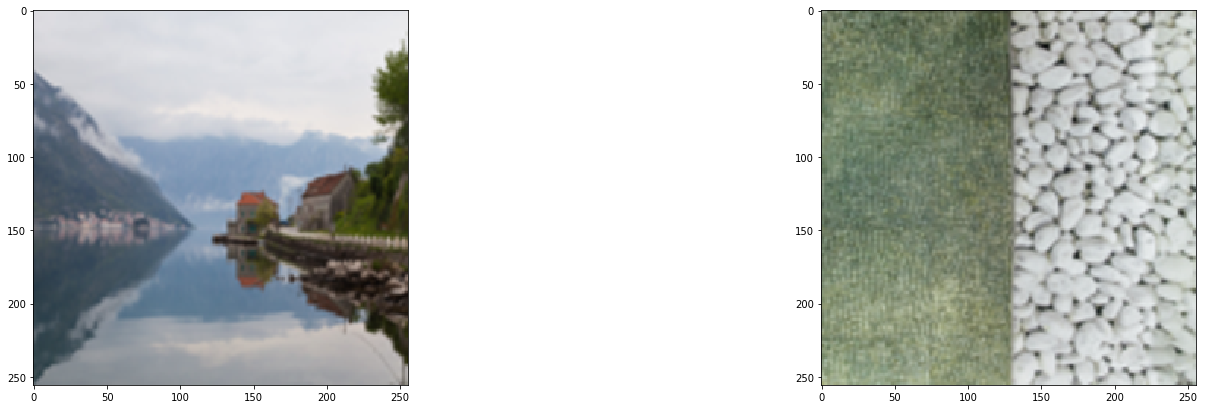

In [12]:
display_images(image_data_l[3:5], columns=3, rows=5, figsize_in=(40, 40))

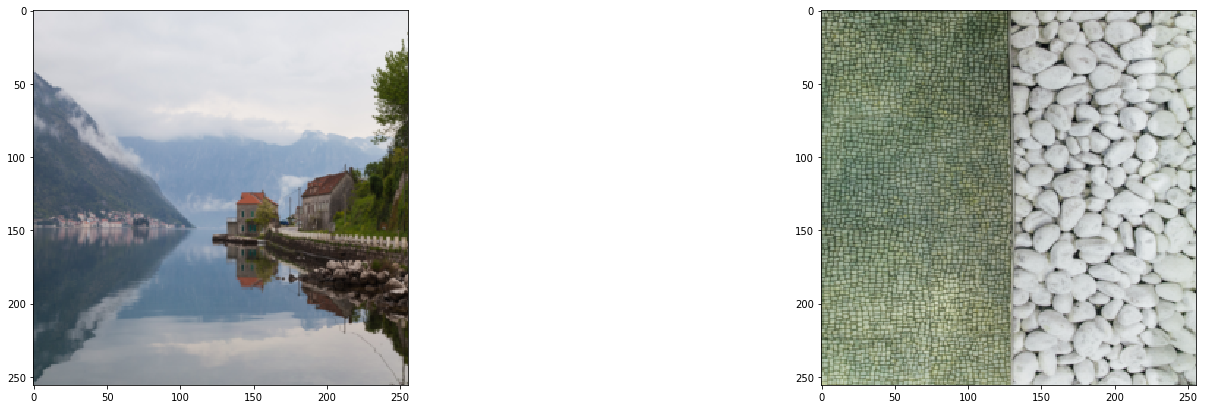

In [13]:
display_images(image_data_h[3:5], columns=3, rows=5, figsize_in=(40, 40))

In [14]:
import numpy as np
print (np.array(image_data_l).shape)
print (np.array(image_data_h).shape)

(50, 256, 256, 3)
(50, 256, 256, 3)


In [15]:
from keras.models import Sequential
from keras.layers import Conv2D, Input, BatchNormalization
# from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD, Adam
import numpy
import math

def model(input_resolution):
    # lrelu = LeakyReLU(alpha=0.1)
    SRCNN = Sequential()
    i_shape = (input_resolution[0], input_resolution[1], 3)
    print ("input_shape : {}".format(i_shape))
    SRCNN.add(Conv2D(kernel_initializer="glorot_uniform", activation="relu", input_shape=i_shape, padding="same", filters=128, use_bias=True, kernel_size=(9, 9)))
    SRCNN.add(Conv2D(kernel_initializer="glorot_uniform", activation="relu", padding="same", filters=64, use_bias=True, kernel_size=(3, 3)))
    # SRCNN.add(BatchNormalization())
    SRCNN.add(Conv2D(kernel_initializer="glorot_uniform", activation="linear", padding="same", filters=3, use_bias=True, kernel_size=(5, 5)))
    adam = Adam(lr=0.0003)
    SRCNN.compile(optimizer=adam, loss='mean_squared_error', metrics=['mean_squared_error'])
    return SRCNN

In [16]:
srcnn = model(test_resolution)

input_shape : (256, 256, 3)
Instructions for updating:
Colocations handled automatically by placer.


In [17]:
srcnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 256, 256, 128)     31232     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 256, 64)      73792     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 256, 256, 3)       4803      
Total params: 109,827
Trainable params: 109,827
Non-trainable params: 0
_________________________________________________________________


## Train & save weights

In [19]:
result = srcnn.fit(np.array(image_data_l), np.array(image_data_h), batch_size=6, nb_epoch=16)

Epoch 1/16
50/50 [==============================] - 65s - loss: 891.7279 - mean_squared_error: 891.7279    
Epoch 2/16
50/50 [==============================] - 66s - loss: 650.7213 - mean_squared_error: 650.7213    
Epoch 3/16
50/50 [==============================] - 66s - loss: 576.1488 - mean_squared_error: 576.1488    
Epoch 4/16
50/50 [==============================] - 65s - loss: 500.5466 - mean_squared_error: 500.5465    
Epoch 5/16
50/50 [==============================] - 65s - loss: 428.4893 - mean_squared_error: 428.4893    
Epoch 6/16
50/50 [==============================] - 66s - loss: 383.0933 - mean_squared_error: 383.0933    
Epoch 7/16
50/50 [==============================] - 66s - loss: 340.4429 - mean_squared_error: 340.4429    
Epoch 8/16
50/50 [==============================] - 65s - loss: 308.7396 - mean_squared_error: 308.7396    
Epoch 9/16
50/50 [==============================] - 65s - loss: 288.4649 - mean_squared_error: 288.4649    
Epoch 10/16
50/50 [=========

In [29]:
srcnn.save_weights("model.h5")

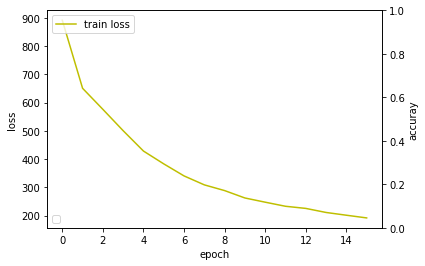

In [20]:
show_train_progress(result)

## Load weights

In [48]:
srcnn.load_weights("model.h5")

## Evaluate

In [21]:
# TODO
# Train me with GPU, many epoches (CPU : took over 30 mins just 10 epoches)
# anyway image is changed a slightly, 

In [39]:
preds = srcnn.predict(np.array(image_data_l[7:15]))

In [40]:
preds = preds.astype(int)

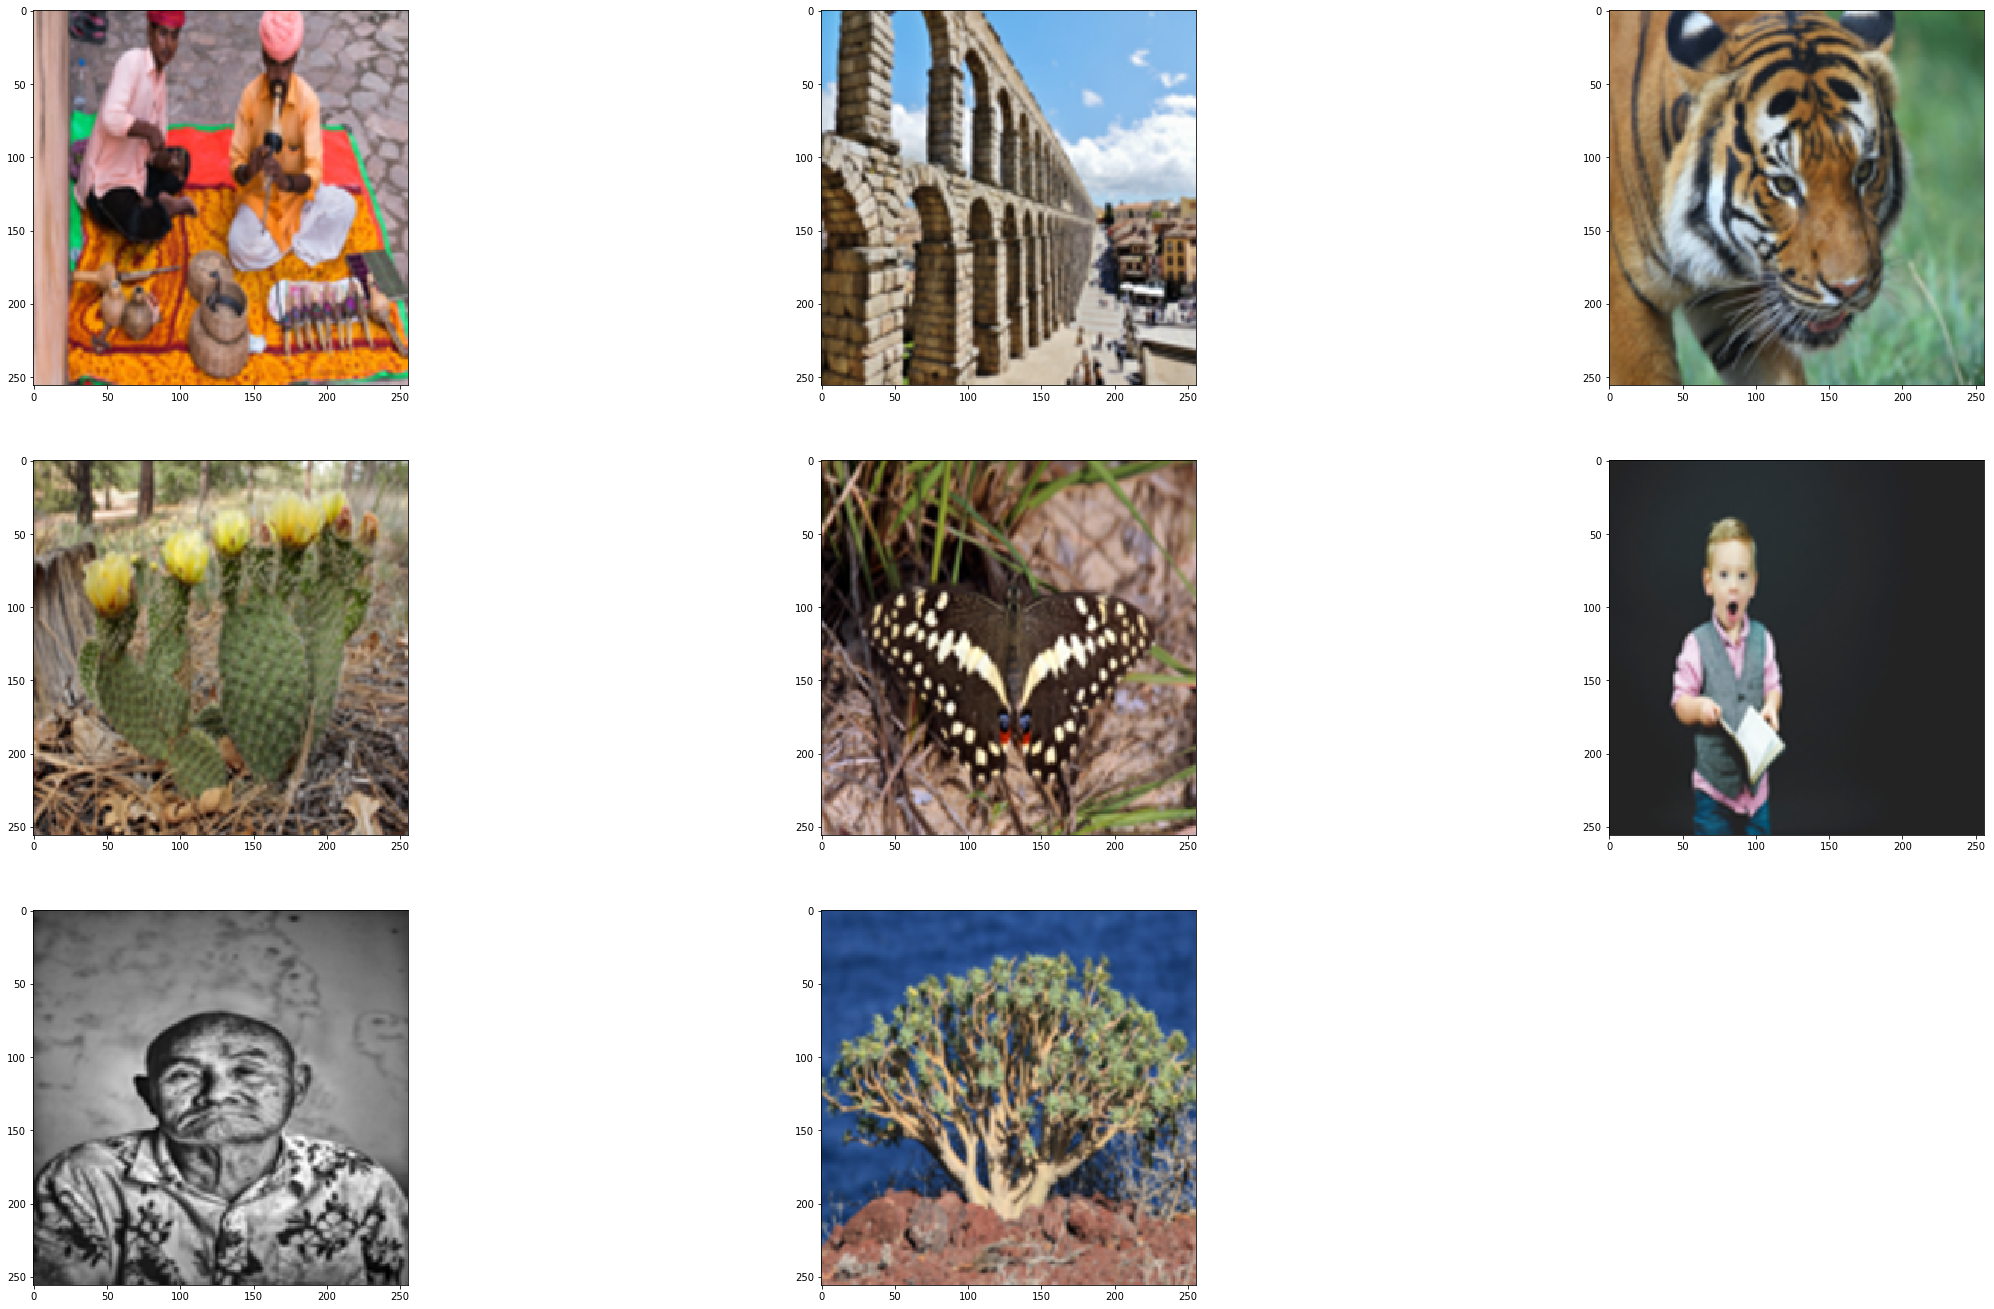

In [42]:
display_images(image_data_l[7:15], columns=3, rows=5, figsize_in=(40, 40))

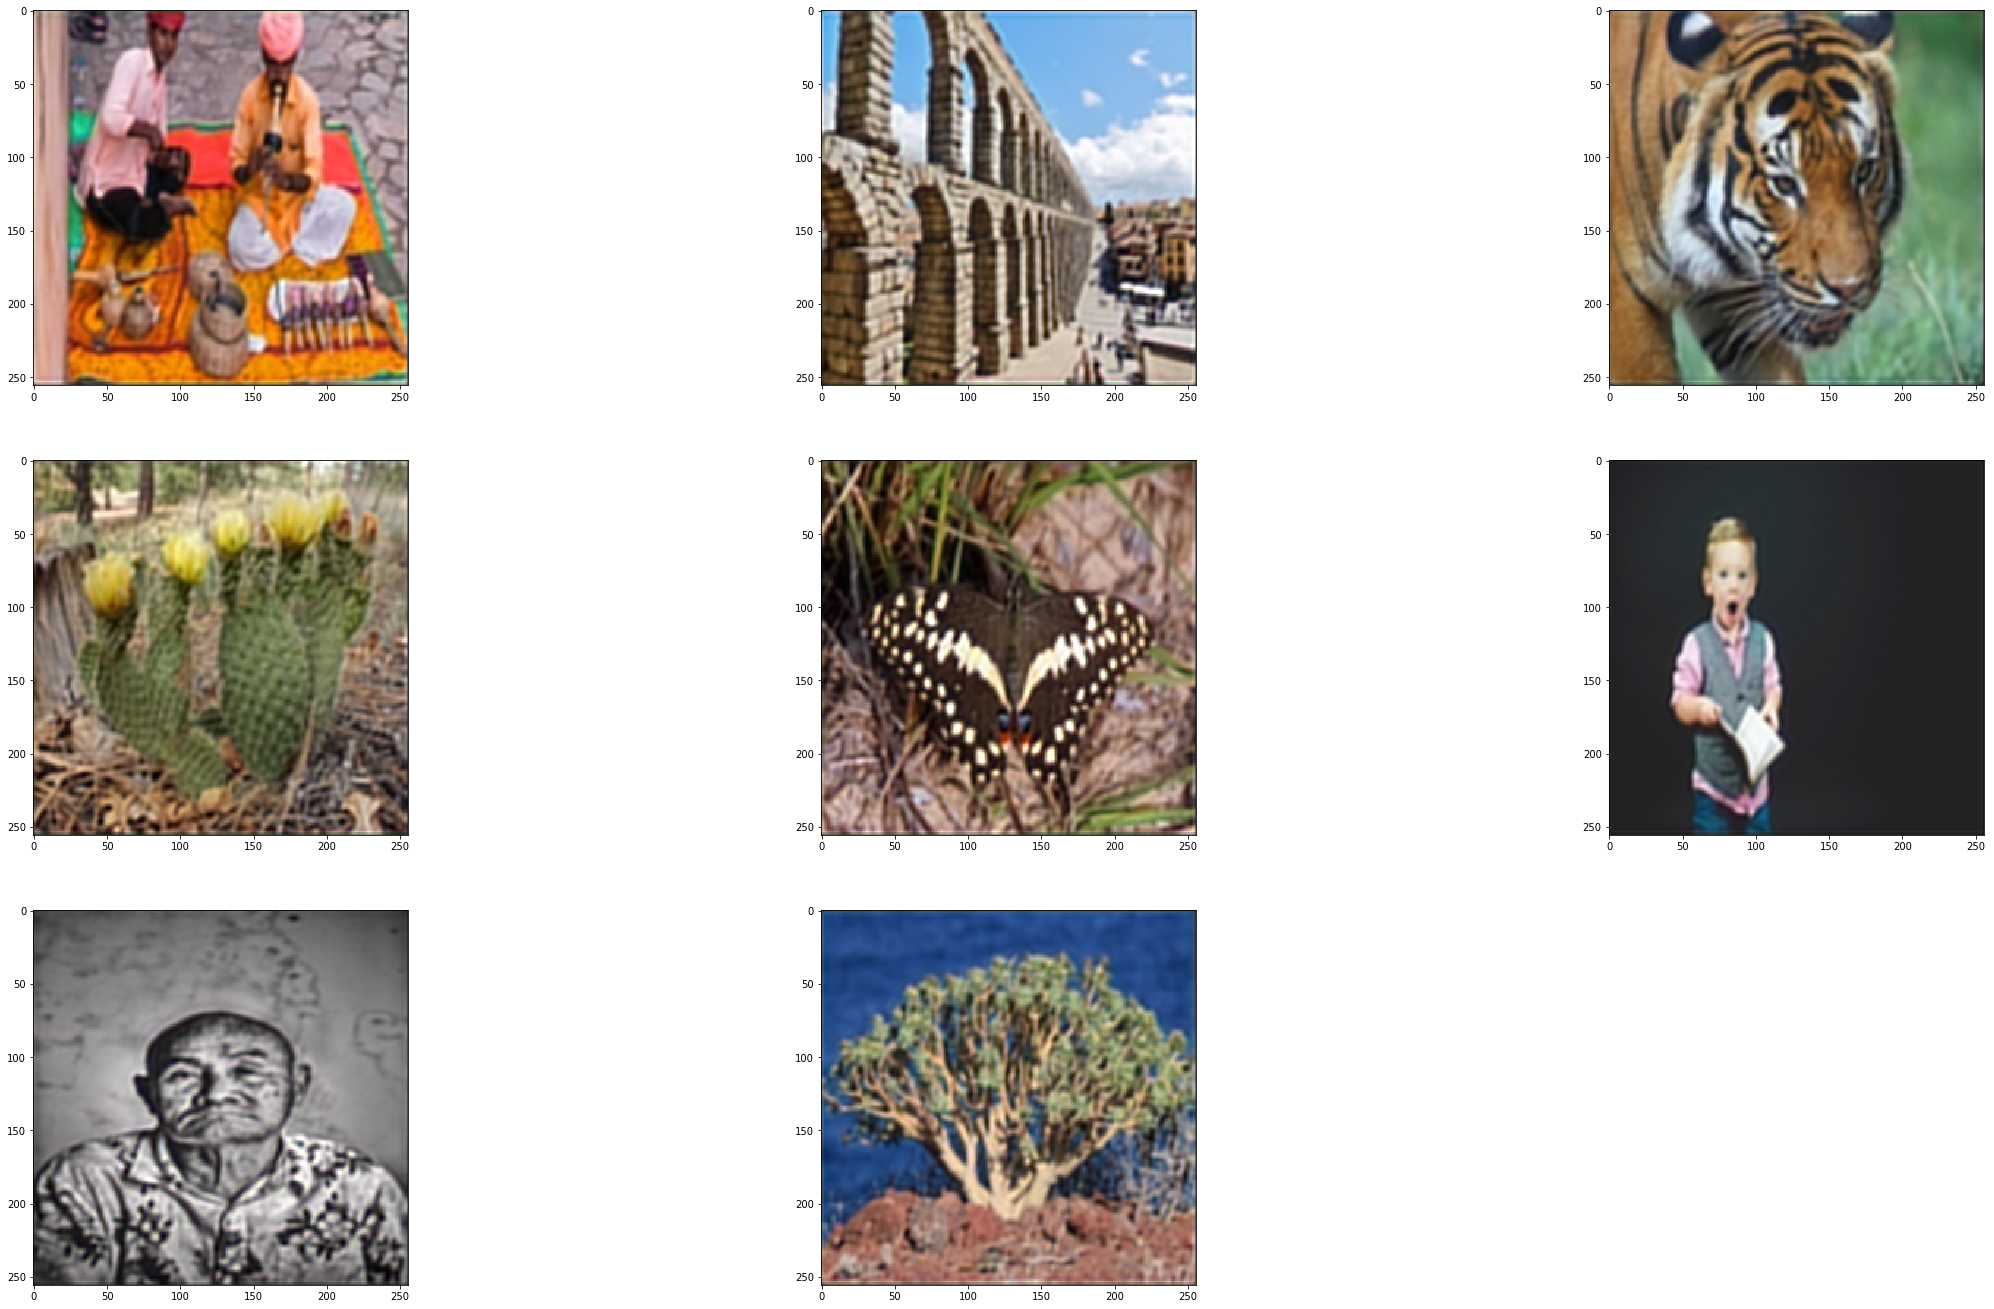

In [43]:
display_images(preds, columns=3, rows=5, figsize_in=(40, 40))

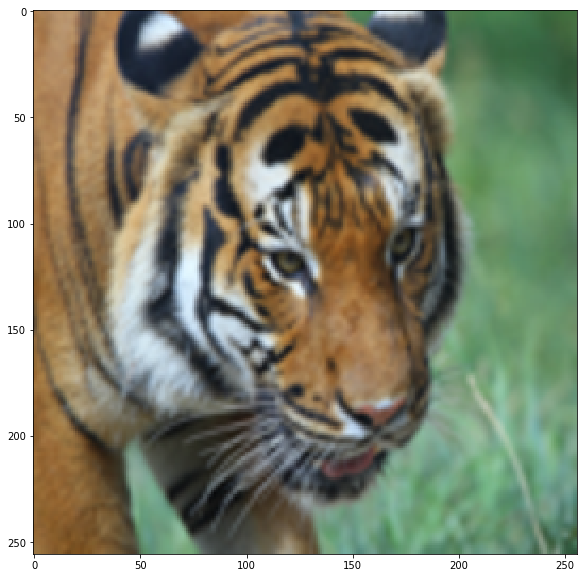

In [46]:
display_image(image_data_l[9])

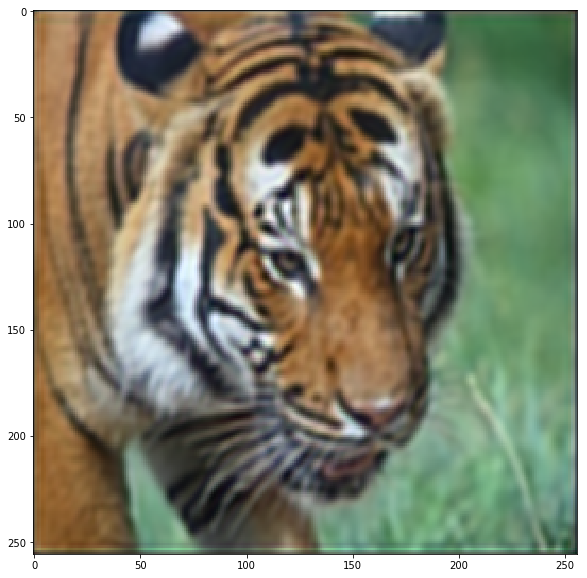

In [45]:
display_image(preds[2])